In [1]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap

In [3]:
#Read errors and take rmse
all_errors=pd.read_csv('../data/'+ 'all_errors_interpolation' + '.csv',index_col=0)
columns=["sigma", "function","rmse_nn_interp.", "rmse_nn_extrap.", "rmse_mdl_interp.", "rmse_mdl_extrap."]
all_errors=all_errors[columns]
display(all_errors)

,sigma,function,rmse_nn_interp.,rmse_nn_extrap.,rmse_mdl_interp.,rmse_mdl_extrap.
0,0.0,tanh,0.047852,0.052995,0.001340,0.011199
1,0.0,tanh,0.015463,0.127937,0.003454,0.454497
2,0.0,tanh,0.111692,0.560637,0.001222,0.069993
3,0.0,tanh,0.033141,0.101108,0.000406,0.048799
4,0.0,tanh,0.010469,0.049501,0.000248,0.003921
...,...,...,...,...,...,...
655,0.2,leaky_ReLU,0.095268,0.309775,0.010784,0.164822
656,0.2,leaky_ReLU,0.307740,1.400525,0.142086,0.234066
657,0.2,leaky_ReLU,0.127973,0.047088,0.041496,0.046699
658,0.2,leaky_ReLU,0.127666,0.105542,0.114628,0.176435


In [4]:
#Melt dataframe: make two columns with the type of errors for the train and the values of the errors
all_errors=pd.melt(all_errors,id_vars=["sigma","function","rmse_nn_extrap.","rmse_mdl_extrap."], var_name="error_interp.",value_name= "value_interp.")

#Melt dataframe: make two columns with the type of errors for the test and the values of the errors
all_errors=pd.melt(all_errors,id_vars=["sigma","function", "error_interp.", "value_interp."], var_name="error_extrap.", value_name= "value_extrap.")

display(all_errors)

,sigma,function,error_interp.,value_interp.,error_extrap.,value_extrap.
0,0.0,tanh,rmse_nn_interp.,0.047852,rmse_nn_extrap.,0.052995
1,0.0,tanh,rmse_nn_interp.,0.015463,rmse_nn_extrap.,0.127937
2,0.0,tanh,rmse_nn_interp.,0.111692,rmse_nn_extrap.,0.560637
3,0.0,tanh,rmse_nn_interp.,0.033141,rmse_nn_extrap.,0.101108
4,0.0,tanh,rmse_nn_interp.,0.010469,rmse_nn_extrap.,0.049501
...,...,...,...,...,...,...
2635,0.2,leaky_ReLU,rmse_mdl_interp.,0.010784,rmse_mdl_extrap.,0.164822
2636,0.2,leaky_ReLU,rmse_mdl_interp.,0.142086,rmse_mdl_extrap.,0.234066
2637,0.2,leaky_ReLU,rmse_mdl_interp.,0.041496,rmse_mdl_extrap.,0.046699
2638,0.2,leaky_ReLU,rmse_mdl_interp.,0.114628,rmse_mdl_extrap.,0.176435


In [5]:
#split in tanh and leaky
errors_tanh=all_errors[all_errors['function']=='tanh']
errors_leaky=all_errors[all_errors['function']=='leaky_ReLU']

display(errors_tanh)
display(errors_leaky)

,sigma,function,error_interp.,value_interp.,error_extrap.,value_extrap.
0,0.0,tanh,rmse_nn_interp.,0.047852,rmse_nn_extrap.,0.052995
1,0.0,tanh,rmse_nn_interp.,0.015463,rmse_nn_extrap.,0.127937
2,0.0,tanh,rmse_nn_interp.,0.111692,rmse_nn_extrap.,0.560637
3,0.0,tanh,rmse_nn_interp.,0.033141,rmse_nn_extrap.,0.101108
4,0.0,tanh,rmse_nn_interp.,0.010469,rmse_nn_extrap.,0.049501
...,...,...,...,...,...,...
2305,0.2,tanh,rmse_mdl_interp.,0.038005,rmse_mdl_extrap.,0.135698
2306,0.2,tanh,rmse_mdl_interp.,0.116825,rmse_mdl_extrap.,0.276772
2307,0.2,tanh,rmse_mdl_interp.,0.116529,rmse_mdl_extrap.,0.030785
2308,0.2,tanh,rmse_mdl_interp.,0.076724,rmse_mdl_extrap.,0.408694


,sigma,function,error_interp.,value_interp.,error_extrap.,value_extrap.
330,0.0,leaky_ReLU,rmse_nn_interp.,0.019390,rmse_nn_extrap.,0.055314
331,0.0,leaky_ReLU,rmse_nn_interp.,0.044218,rmse_nn_extrap.,0.268296
332,0.0,leaky_ReLU,rmse_nn_interp.,0.009902,rmse_nn_extrap.,0.180205
333,0.0,leaky_ReLU,rmse_nn_interp.,0.044113,rmse_nn_extrap.,0.318692
334,0.0,leaky_ReLU,rmse_nn_interp.,0.013290,rmse_nn_extrap.,0.065376
...,...,...,...,...,...,...
2635,0.2,leaky_ReLU,rmse_mdl_interp.,0.010784,rmse_mdl_extrap.,0.164822
2636,0.2,leaky_ReLU,rmse_mdl_interp.,0.142086,rmse_mdl_extrap.,0.234066
2637,0.2,leaky_ReLU,rmse_mdl_interp.,0.041496,rmse_mdl_extrap.,0.046699
2638,0.2,leaky_ReLU,rmse_mdl_interp.,0.114628,rmse_mdl_extrap.,0.176435


In [6]:
#Figure configuration
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=12;size_ticks=10;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

output_path='../results/'

resamples=100000; bs_seed=1111 #number of resamples
ymin=2e-4;ymax=0.75

<Figure size 944.882x708.661 with 0 Axes>

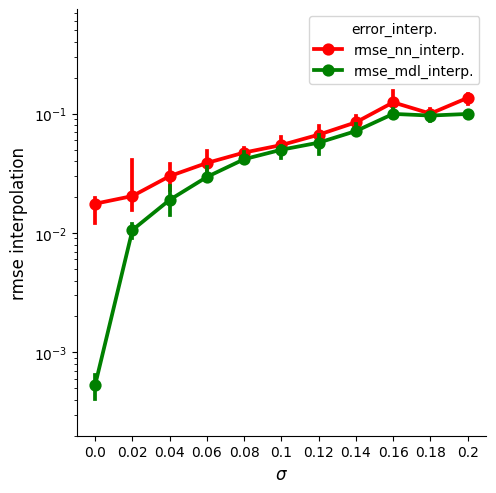

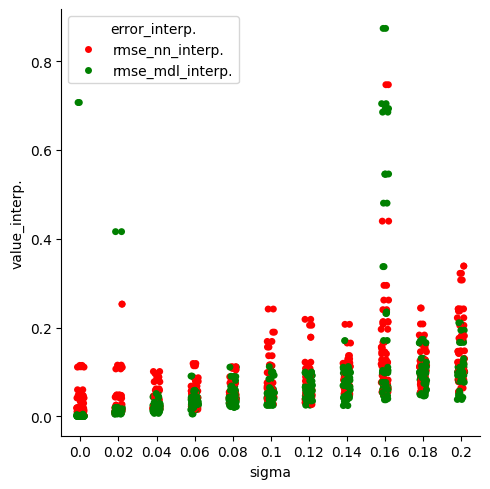

In [7]:
#Plot tanh - rmse train
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh, x='sigma', y='value_interp.', hue="error_interp.", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse interpolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)


name_fig='tanh_rmse_interpolation.svg'
plt.savefig(output_path+name_fig,dpi=300)

sns.catplot(data=errors_tanh, x='sigma', y='value_interp.', hue="error_interp.",palette=['red', 'green'],legend_out=False)
plt.show()

<Figure size 944.882x708.661 with 0 Axes>

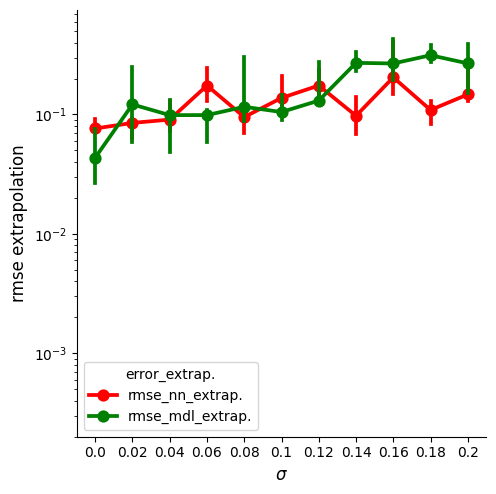

In [8]:
#tanh - rmse test
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_tanh, x='sigma', y='value_extrap.', hue="error_extrap.", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse extrapolation',fontsize=size_axis)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)
name_fig='tanh_rmse_extrapolation.svg'
plt.savefig(output_path+name_fig,dpi=300)

<Figure size 944.882x708.661 with 0 Axes>

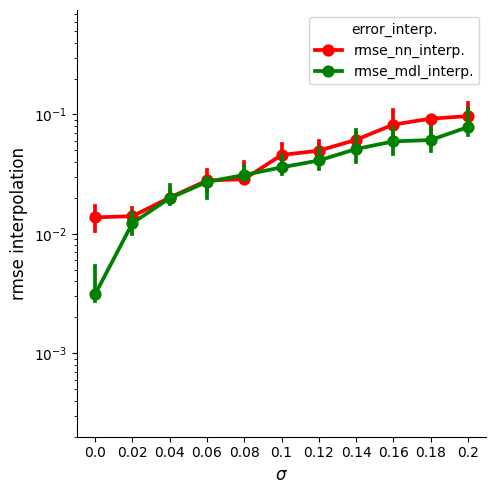

In [10]:
#leaky - rmse interpolation
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_leaky, x='sigma', y='value_interp.', hue="error_interp.", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse interpolation',fontsize=size_axis)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)
name_fig='leaky_rmse_interpolation.svg'
plt.savefig(output_path+name_fig,dpi=300)

<Figure size 944.882x708.661 with 0 Axes>

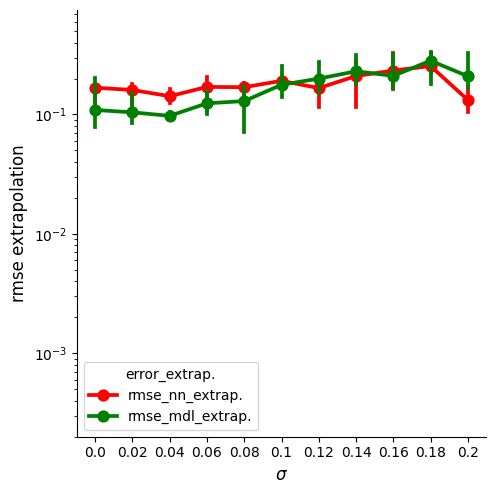

In [11]:
#leaky - rmse extrapolation
fig=figure(figsize=(width,height), dpi=300)

sns.catplot(data=errors_leaky, x='sigma', y='value_extrap.', hue="error_extrap.", kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=['red', 'green'],legend_out=False)
plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse extrapolation',fontsize=size_axis)
#plt.legend(loc='lower right',fontsize=size_ticks,frameon=False)

plt.ylim(ymin,ymax)
name_fig='leaky_rmse_extrapolation.svg'
plt.savefig(output_path+name_fig,dpi=300)